### Evaluation des 10 meilleurs modèles issus de l'optimisation des hyperparamètres

#### Importation des modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
import qsar_utils as qu
from plotnine import *
import ast

#### Chargement des données

In [3]:
df_norm = pd.read_csv("/home/be203133/projet_IA_QSAR/data/qsar_fish_toxicity_norm_train.csv")
LC50 = df_norm["LC50"]
data = df_norm.drop(columns=["LC50"])
best_models = pd.read_csv("nested_MLP_2/best_models.csv")
best_models = best_models[["nb_neurones","alpha","activation","hidden_layer_sizes","learning_rate_init"]]
# conversion de la colonne avec les couches en tuple
best_models["hidden_layer_sizes"] = best_models["hidden_layer_sizes"].apply(lambda x: ast.literal_eval(x))

#### Entrainement des 10 meilleurs modèles 5 fois en cross validation
**/!\\ Ceci est très long (environ une nuit sur le serveur)**

Après la mise au point des meilleurs hyperparamètres, on effectue une validation croisée avec ces derniers pour identifier le meilleur modèle

In [ ]:
df_final = pd.DataFrame(columns=["nb_neurones","alpha","activation","hidden_layer_sizes","learning_rate_init","no_AD","strict","soft"])
n_model_tot = len(best_models)
cpt =  0
for model in best_models.iterrows(): # parcours des modèles
    cpt += 1
    param = model[1].to_dict() # conversion des lignes en dictionnaires pour la praticité
    scores = {"no_AD": [], "strict": [], "soft": []} # initialisation des scores
    mean_score = {"no_AD": 0, "strict": 0, "soft": 0}
    for i in range(5): # on boucle 5 fois pour la cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42+i) # on split les données en 5, 5 fois différemment
        for train_index, test_index in kf.split(data):
            knn = NearestNeighbors(n_neighbors=6, metric='euclidean') # initialisation du knn
            model = MLPRegressor( # initialisation du modèle
                activation=param["activation"],
                alpha=param["alpha"],
                hidden_layer_sizes=param["hidden_layer_sizes"],
                learning_rate_init=param["learning_rate_init"],
                random_state=42,
                max_iter = 100000
            )
            X_train, X_test = data.iloc[train_index], data.iloc[test_index] # on récupère les données
            y_train, y_test = LC50.iloc[train_index], LC50.iloc[test_index]
            model.fit(X_train, y_train) # entrainement du modèle
            y_pred = model.predict(X_test) # prédictions
            # Calculd es score et stockage
            score_noAD,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=None)
            score_strict,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=0.13)
            score_soft,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=0.2)
            scores["no_AD"].append(score_noAD)
            scores["strict"].append(score_strict)
            scores["soft"].append(score_soft)
    # calcul des moyennes des scores pour chaque modèle
    row_final = pd.DataFrame({"nb_neurones": [param["nb_neurones"]],"alpha": [param["alpha"]],"activation": [param["activation"]],
                              "hidden_layer_sizes": [param["hidden_layer_sizes"]],"learning_rate_init": [param["learning_rate_init"]],
                              "no_AD": [np.mean(scores["no_AD"])], "no_AD_sd": [np.std(scores["no_AD"])],
                              "strict": [np.mean(scores["strict"])],"strict_sd": [np.std(scores["strict"])],
                              "soft": [np.mean(scores["soft"])],"soft_sd": [np.std(scores["soft"])]})
    df_final = pd.concat([df_final, row_final])
    df_final.to_csv("nested_MLP_2/Evalution_finale_temp.csv", index=False)
    print(f"{cpt}/{n_model_tot}", end = "\r")
print(f'{cpt}/{n_model_tot}')
df_final.to_csv("nested_MLP_2/Evalution_finale.csv", index=False)

/tmp/ipykernel_415792/2282275485.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, row_final])


/home/be203133/.conda/envs/projet_ia/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [2]:
df_final = pd.read_csv("nested_MLP_2/Evalution_finale.csv")
df_final["num_model"] = df_final.index

#### Visualisation des résultats

In [3]:
df_final.sort_values(by="no_AD", ascending=False, inplace=True)
df_final

,nb_neurones,alpha,activation,hidden_layer_sizes,learning_rate_init,no_AD,strict,soft,no_AD_sd,strict_sd,soft_sd,num_model
21,500,0.005044,relu,"(56, 56, 56, 56, 56, 55, 55, 55, 55)",0.000028,0.620829,0.721395,0.661284,0.066247,0.047706,0.052442,21
5,1000,0.000542,relu,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.000021,0.613199,0.728026,0.662758,0.069170,0.049804,0.051067,5
4,500,0.004054,relu,"(56, 56, 56, 56, 56, 55, 55, 55, 55)",0.000051,0.610698,0.724855,0.657524,0.066749,0.043627,0.050866,4
8,50,0.000076,relu,"(5, 5, 5, 5, 5, 5, 5, 5, 5, 5)",0.001118,0.609857,0.704322,0.647117,0.060933,0.047562,0.052864,8
12,10,0.001876,tanh,"(4, 3, 3)",0.003510,0.609005,0.705813,0.648180,0.058152,0.051233,0.052037,12
28,1000,0.002793,relu,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.000010,0.605410,0.704285,0.647785,0.064582,0.054721,0.055316,28
1,200,0.072867,relu,"(100, 100)",0.000348,0.602524,0.722252,0.658273,0.066168,0.048068,0.051896,1
19,100,0.001407,tanh,"(20, 20, 20, 20, 20)",0.001227,0.602490,0.707060,0.644723,0.059210,0.053840,0.053018,19
11,2000,0.000993,relu,"(500, 500, 500, 500)",0.000013,0.602033,0.736167,0.663550,0.073806,0.047774,0.052459,11
0,200,0.036999,relu,"(100, 100)",0.000251,0.601808,0.722819,0.656792,0.067540,0.048596,0.050745,0


In [4]:
def gglineplot(df, x, y, df_best , title, xlabel, ylabel):
    """
    Fonction pour tracer les performances des modèles sous forme de scatter plot
    On utiliser plotnine pour sa simplicité d'édition des graphiques (ajout des textes)
    """
    plot = (
        ggplot(data = df, mapping = aes(x = x, y = y)) 
        + geom_point(size = 3) 
        + geom_line(size = 1) 
        # + geom_errorbar(aes(ymin = df[y] - df[y+"_sd"], ymax = df[y] + df[y+"_sd"]), width = 0.2)
        + geom_text(aes(label = "num_model"), data = df_best, nudge_y = 0.015, color = "red", size = 16)
        + theme_bw()
        + xlab(xlabel)
        + ylab(ylabel)
        + ggtitle(title)
        + theme(axis_text = element_text(size = 14), 
                axis_title = element_text(size = 14),
                plot_title = element_text(size = 16),
                figure_size=(10,6))
    )
    return plot


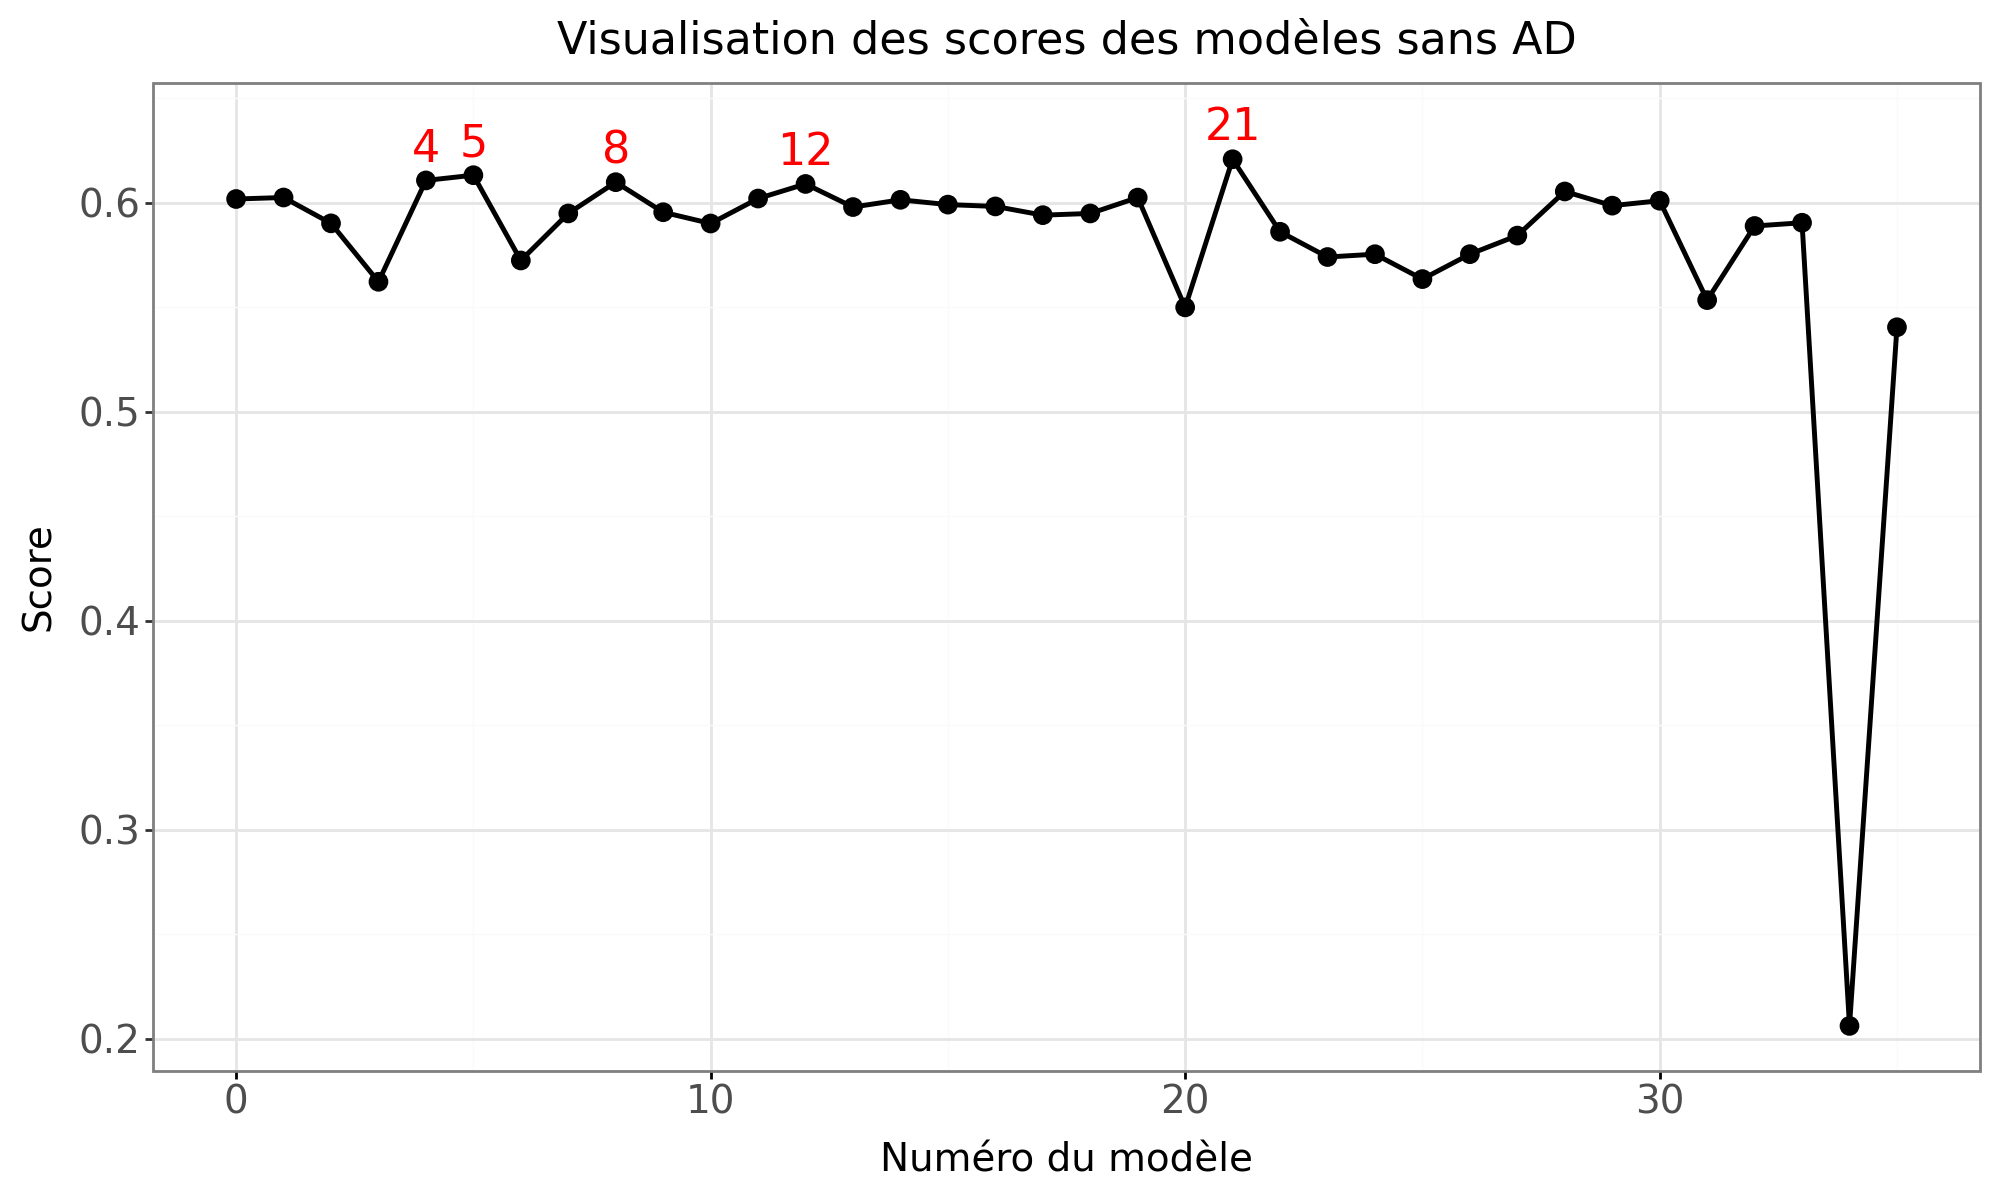

In [5]:
# Extraction des 5 meilleurs modèles
df_best = df_final.nlargest(5, "no_AD").copy()
p = gglineplot(df_final, "num_model", "no_AD", df_best, 
               "Visualisation des scores des modèles sans AD", "Numéro du modèle", "Score")
p

- Performances avec le seuil strict

Il faut attention ici, car les modèles qui performants sont surement biaisés par du surapprentissage (valeurs de test plus proches des valeurs d'entraînement)

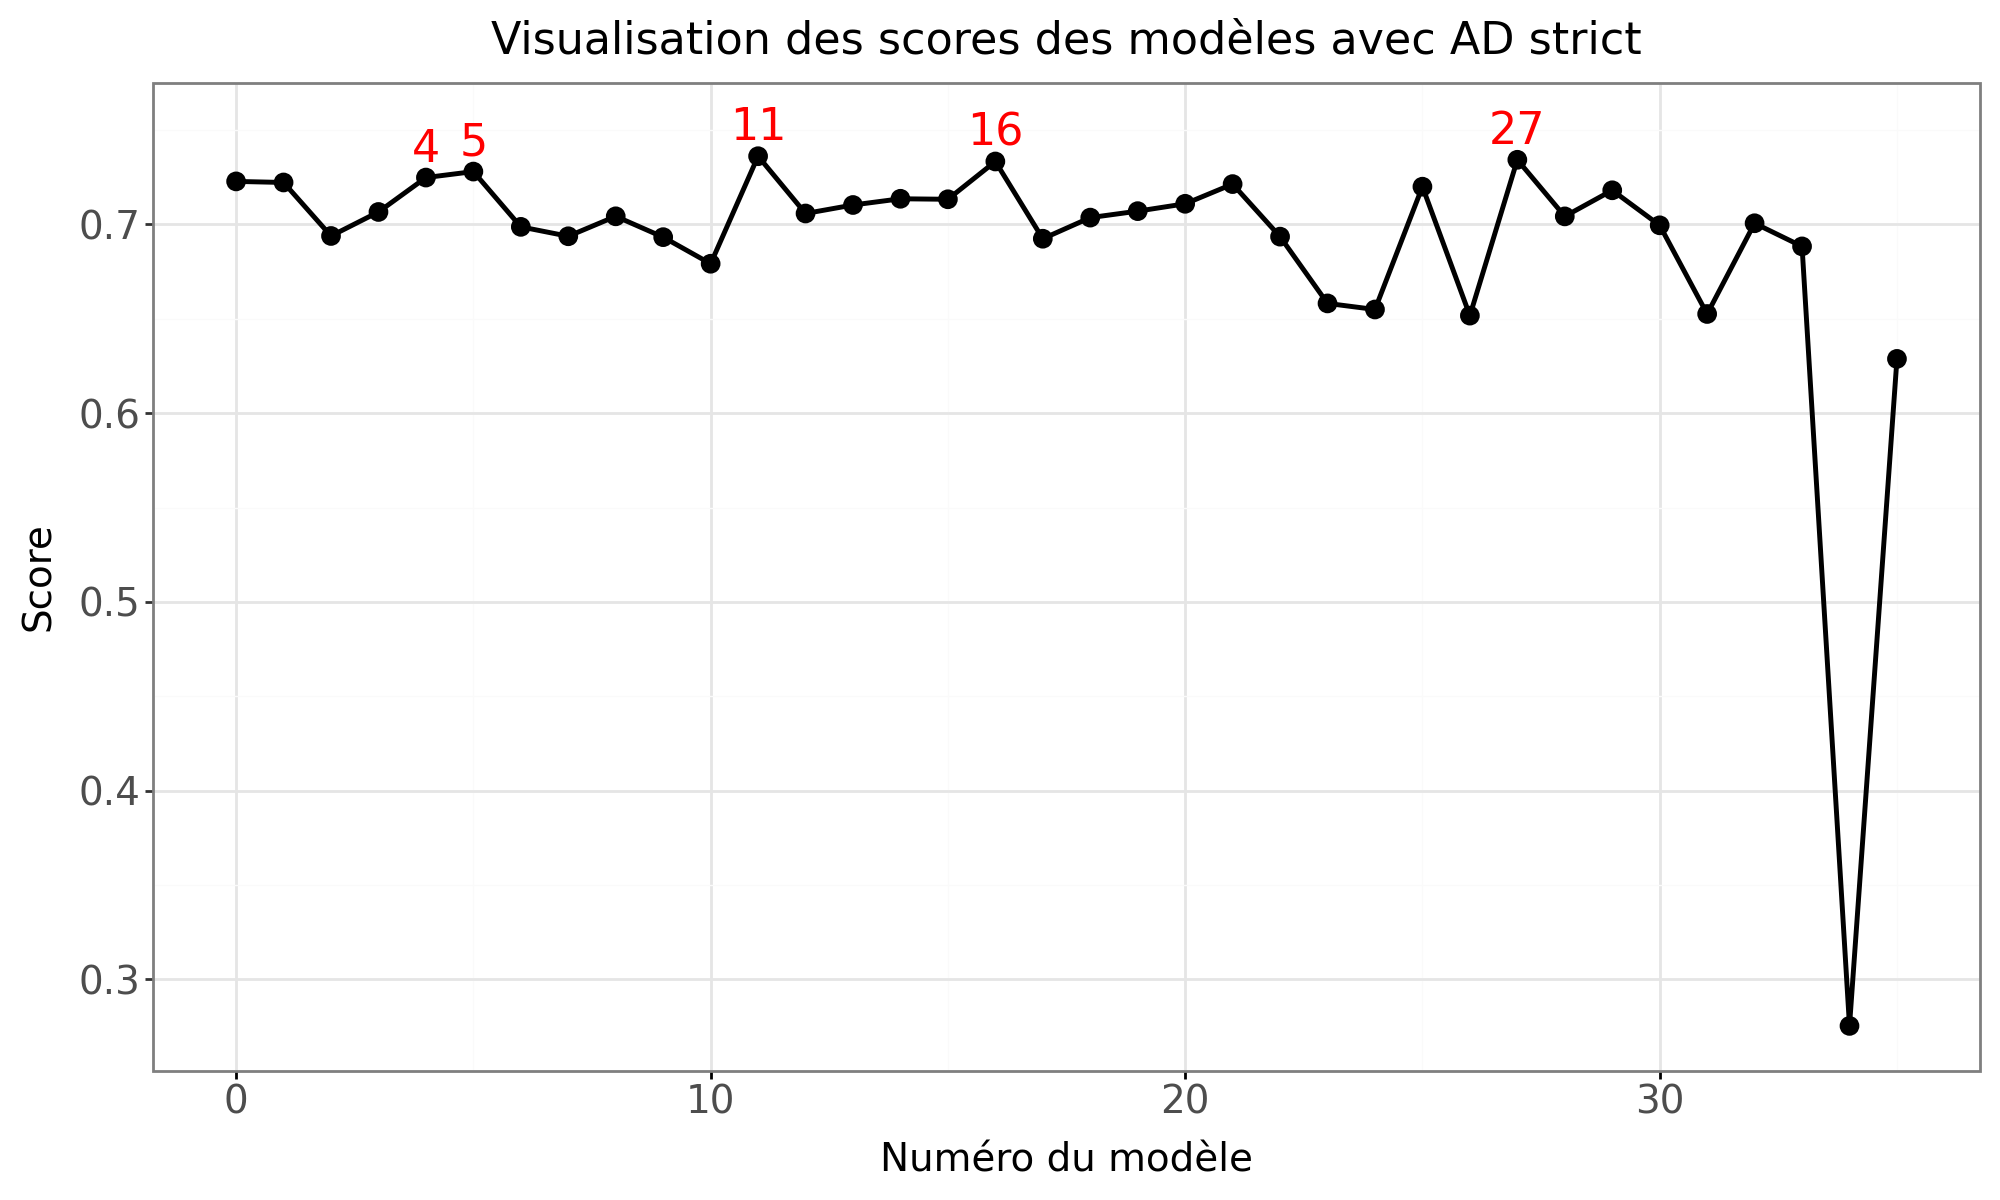

In [6]:
df_best = df_final.nlargest(5, "strict").copy()
p = gglineplot(df_final, "num_model", "strict", df_best, 
               "Visualisation des scores des modèles avec AD strict", "Numéro du modèle", "Score")
p

- Performances avec le seuil souple de l'AD

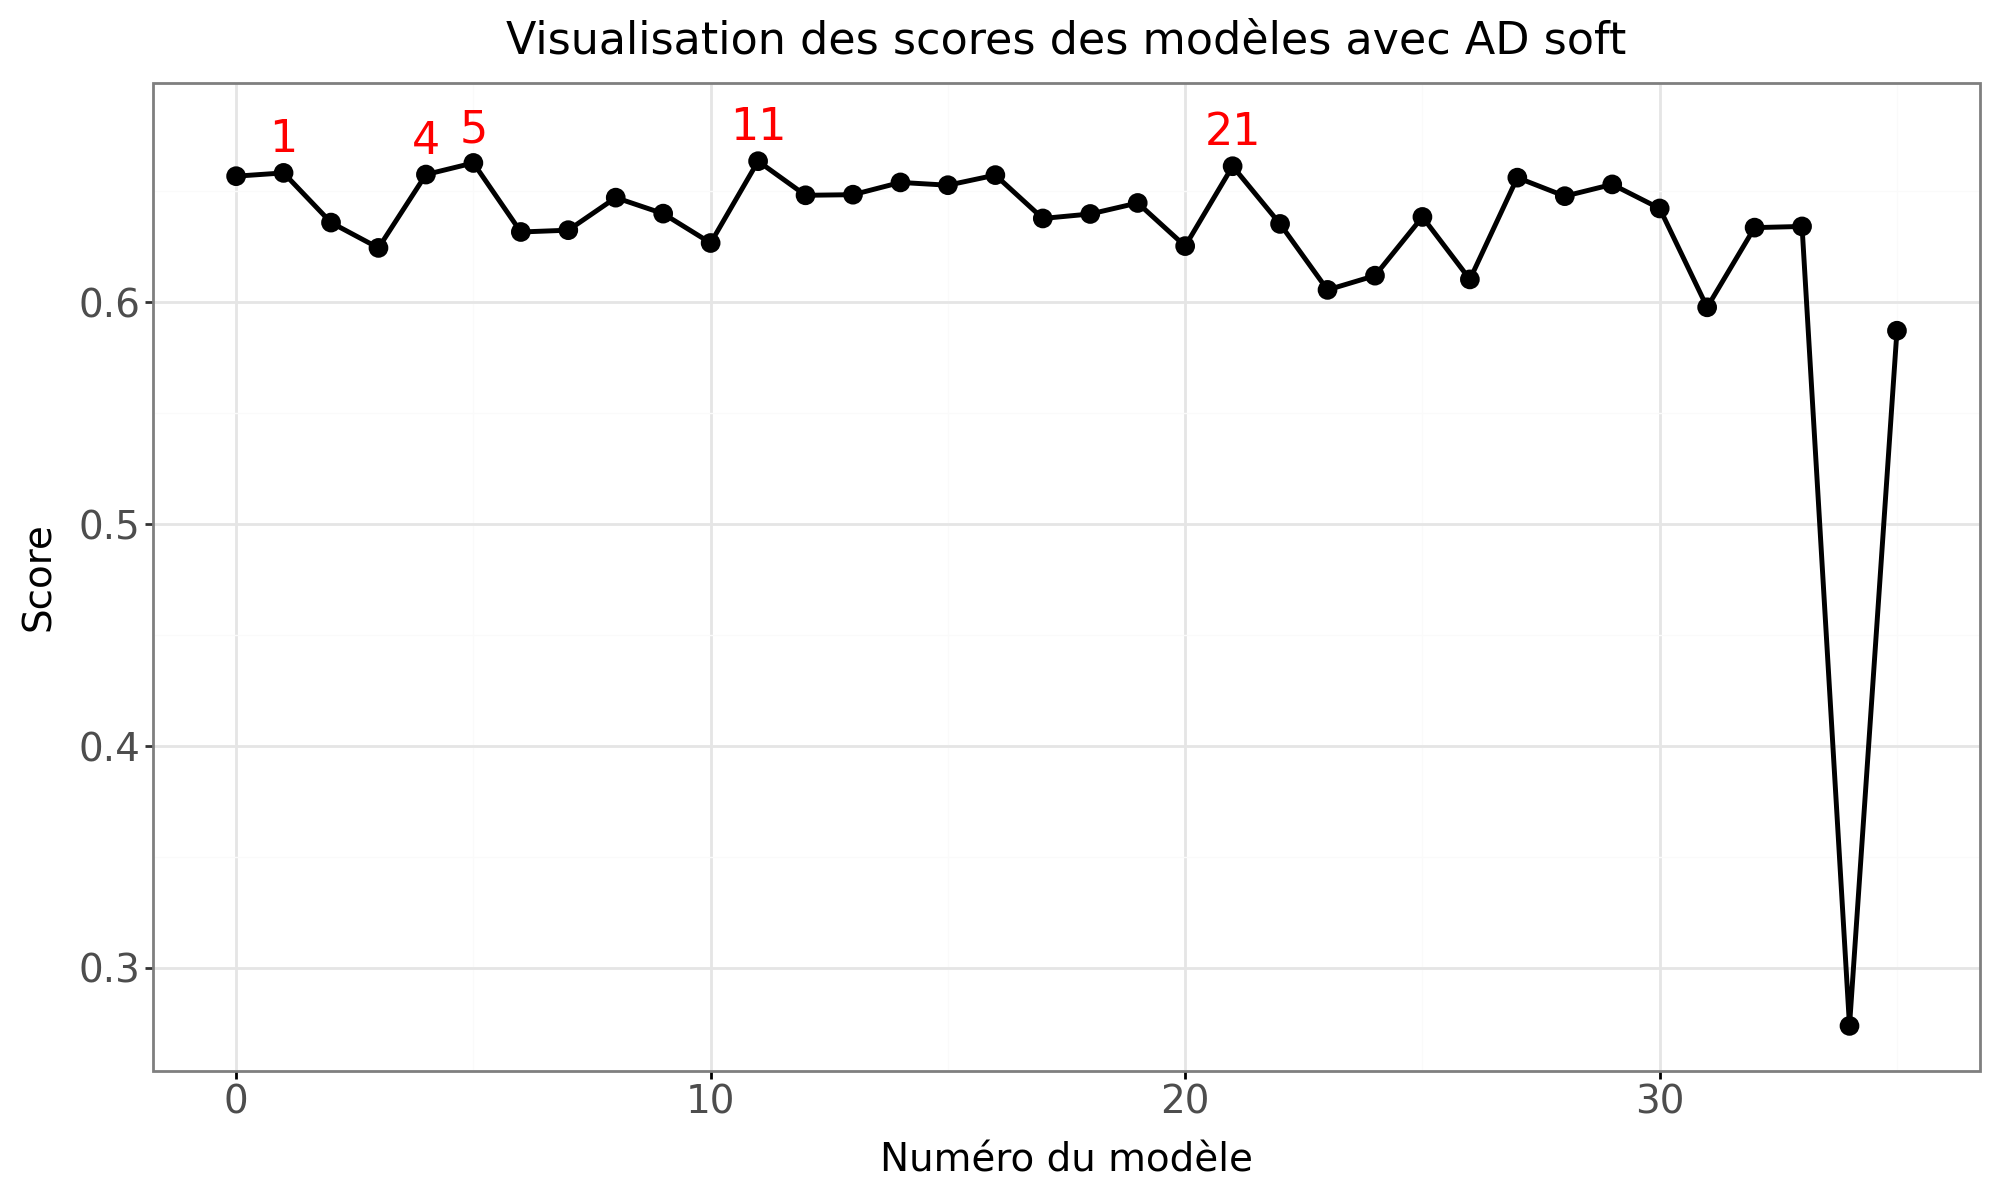

In [7]:
df_best = df_final.nlargest(5, "soft").copy()
p = gglineplot(df_final, "num_model", "soft", df_best, 
               "Visualisation des scores des modèles avec AD soft", "Numéro du modèle", "Score")
p

- Le modèle 4 à 500 neurones généralise le mieux sur des données de tests assez lointaines (pas d'AD) et fait partie des meilleurs avec un fitre souple et strict.

### Mise en place du modèle à 500 neurones sur les données de test

- Entrainement du modèle avec les paramètres associés

In [8]:
df_norm_train = pd.read_csv("data/qsar_fish_toxicity_norm_train.csv")
df_norm_train_LC50 = df_norm_train["LC50"]
df_norm_train = df_norm_train.drop(columns=["LC50"])
df_norm_test = pd.read_csv("data/qsar_fish_toxicity_norm_test.csv")
df_norm_test_LC50 = df_norm_test["LC50"]
df_norm_test = df_norm_test.drop(columns=["LC50"])

mlp = MLPRegressor(hidden_layer_sizes=(56, 56, 56, 56, 56, 55, 55, 55, 55),
                     max_iter=100000,
                     alpha=0.004054,
                     solver='adam',
                     activation='relu',
                     learning_rate_init=0.000051)
print("Entrainement du modèle")
mlp.fit(df_norm_train, df_norm_train_LC50)
print("Prédiction du modèle")
predicted = mlp.predict(df_norm_test)

Entrainement du modèle
Prédiction du modèle


- Performances

In [11]:
dict_results = qu.evaluate_MLP(X_train_outer=df_norm_train,
                               X_test_outer=df_norm_test,
                               y_test_outer=df_norm_test_LC50,
                               y_pred_outer=predicted,
                               knn = NearestNeighbors(n_neighbors=6, metric='euclidean'),
                               threshold_strict=0.13,
                               threshold_soft=0.2)

for keys, values in dict_results.items():
    print(f"Results for {keys} : Qsquared = {values[0]:.3f}, molecules inside AD = {values[1]}, molecules out of AD = {values[2]}")

Results for no_AD : Qsquared = 0.610, molecules inside AD = 182, molecules out of AD = 0
Results for strict : Qsquared = 0.737, molecules inside AD = 107, molecules out of AD = 75
Results for soft : Qsquared = 0.650, molecules inside AD = 152, molecules out of AD = 30


- Filtration des données selon l'AD pour les graphiques

In [12]:
y_pred_strict, y_test_strict, _ = qu.apply_AD(X_train = df_norm_train,
                                            X_test = df_norm_test,
                                            y_test = df_norm_test_LC50,
                                            y_pred_test = predicted,
                                            knn = NearestNeighbors(n_neighbors=6, metric='euclidean'), threshold=0.13)

y_pred_soft, y_test_soft, _ = qu.apply_AD(X_train = df_norm_train,
                                        X_test = df_norm_test,
                                        y_test = df_norm_test_LC50,
                                        y_pred_test = predicted,
                                        knn = NearestNeighbors(n_neighbors=6, metric='euclidean'), threshold=0.20)

- Scatter plot sans filtre

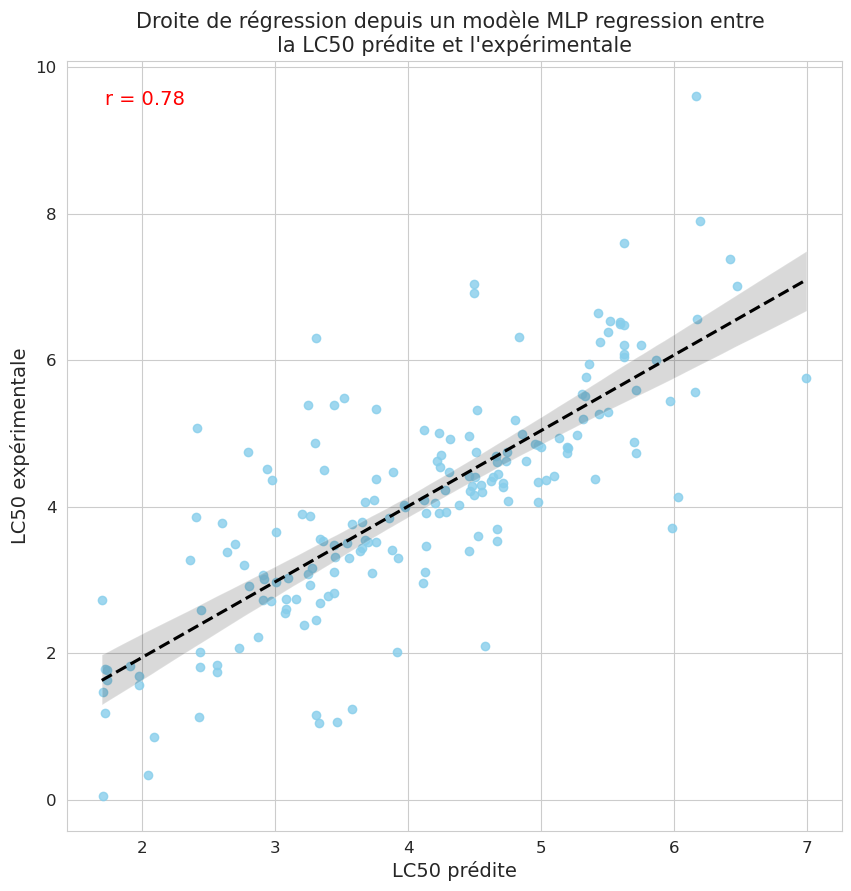

In [13]:
corr_coef = pearsonr(df_norm_test_LC50, predicted)[0]
qu.scatter_QSAR(x_data=predicted, 
                corr_coef=corr_coef,
                y_data = df_norm_test_LC50, 
                model_type="MLP regression")

- Scatter plot avec le filtre strict

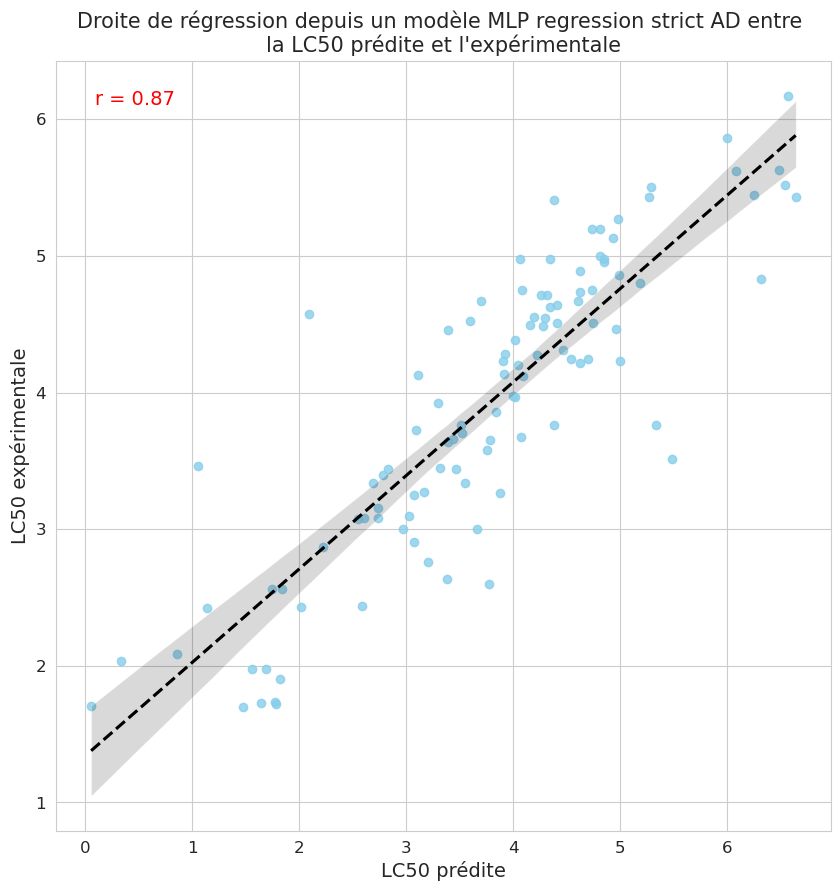

In [14]:
corr_coef = pearsonr(y_test_strict, y_pred_strict)[0]
qu.scatter_QSAR(x_data=y_pred_strict, 
                corr_coef=corr_coef,
                y_data = y_test_strict, 
                model_type="MLP regression strict AD")

- Scatter plot avec le seuil souple

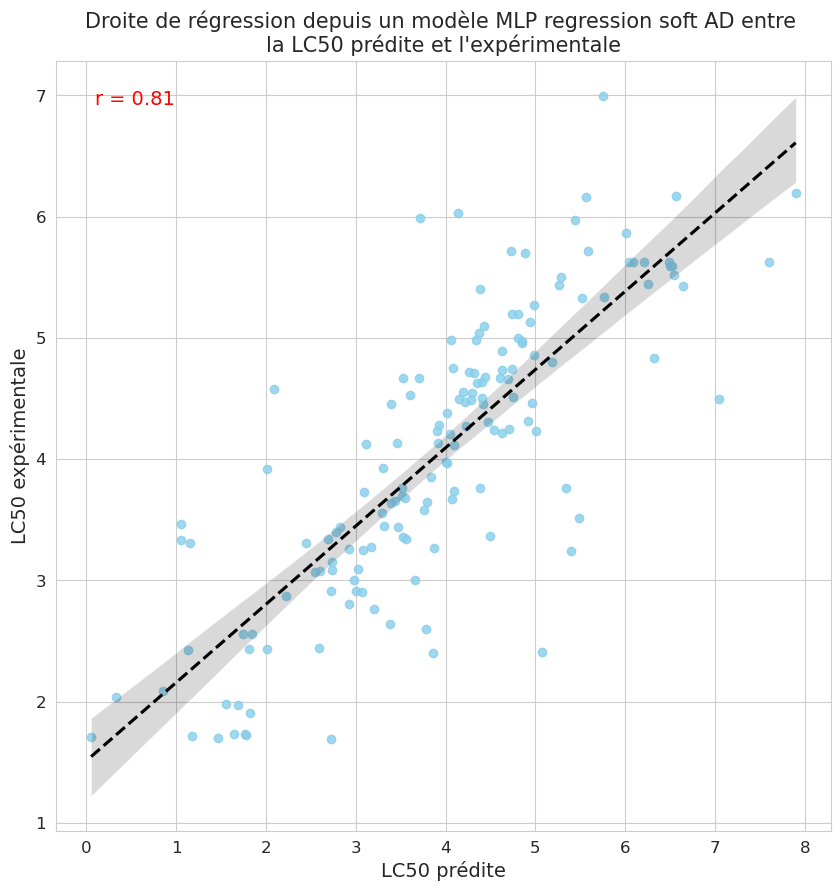

In [15]:
cor_coeff = pearsonr(y_test_soft, y_pred_soft)[0]
qu.scatter_QSAR(x_data=y_pred_soft, 
                corr_coef=cor_coeff,
                y_data = y_test_soft, 
                model_type="MLP regression soft AD")